In [1]:
#
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt 

/Users/charlieturner/Documents/CountingBoats
Date range: 2016-07-23 00:00:00 2024-06-24 00:00:00
Number of days: 2894
Days we have: 451
Missing days: 2443


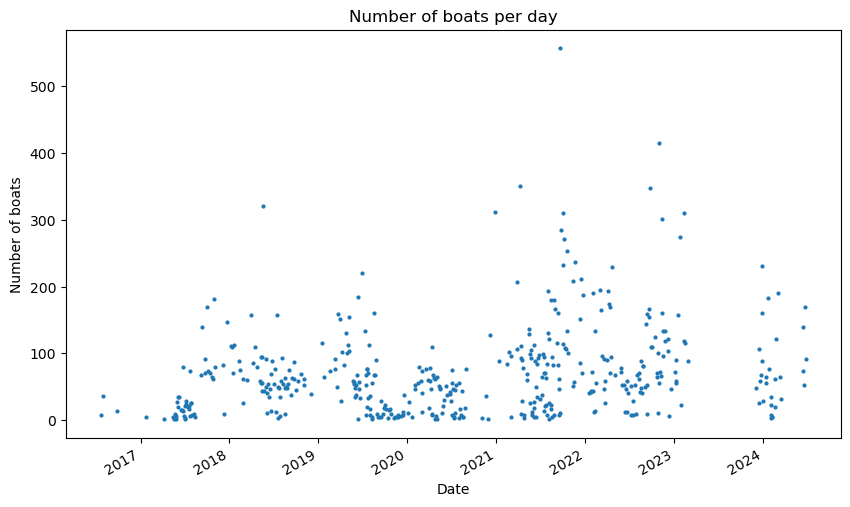

In [2]:
%cd /Users/charlieturner/Documents/CountingBoats
from counting_boats.utils.area_coverage import is_inside
from counting_boats.utils.planet_utils import get_aois

aois = [
    ('peel', 'data/polygons/peel.json'),
    ('tangalooma', 'data/polygons/tangalooma.json'),
    ('south_bribie', 'data/polygons/south_bribie.json')
]


# load the data
data1 = pd.read_csv("visualisation/data/alex_boats.csv")
data1['date'] = pd.to_datetime(data1['date'], dayfirst=True)

data2 = pd.read_csv("visualisation/data/boat_counts_23_24.csv")
data2['date'] = pd.to_datetime(data2['date'], dayfirst=True)

data3 = pd.read_csv("visualisation/data/boat_counts_24.csv")
data3['date'] = pd.to_datetime(data3['date'], dayfirst=True)

data = pd.concat([data1, data2, data3]).sort_values('date').reset_index(drop=True)

data = data[data['AOI'] != 'unknown']

print("Date range:", data['date'].min(), data['date'].max())
date_range = pd.date_range(data['date'].min(), data['date'].max())
print("Number of days:" , len(date_range))
print("Days we have:", len(pd.unique(data['date'])))
# print the number of missing dates within that range
missing_dates = date_range[~date_range.isin(data['date'])]
print("Missing days:", len(missing_dates))

counts = data.groupby('date').size()

# plot the number of boats per day (marker size 5)
ax = counts.plot(x='date', y='count', style='o', figsize=(10, 6), markersize=2)
ax.set_xlabel("Date")
ax.set_ylabel("Number of boats")
ax.set_title("Number of boats per day")
plt.show()

In [3]:
data.head()

,date,class,latitude,longitude,confidence,AOI,images,w,h
0,2016-07-23,0.0,-27.029093,153.099683,0.602136,southBribie,NaN,NaN,NaN
1,2016-07-23,0.0,-27.043734,153.131123,0.782813,southBribie,NaN,NaN,NaN
2,2016-07-23,0.0,-27.073810,153.147421,0.690460,southBribie,NaN,NaN,NaN
3,2016-07-23,0.0,-27.069445,153.138789,0.832270,southBribie,NaN,NaN,NaN
4,2016-07-23,0.0,-27.028120,153.097550,0.746432,southBribie,NaN,NaN,NaN


/Users/charlieturner/miniforge3/envs/boats/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/charlieturner/miniforge3/envs/boats/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


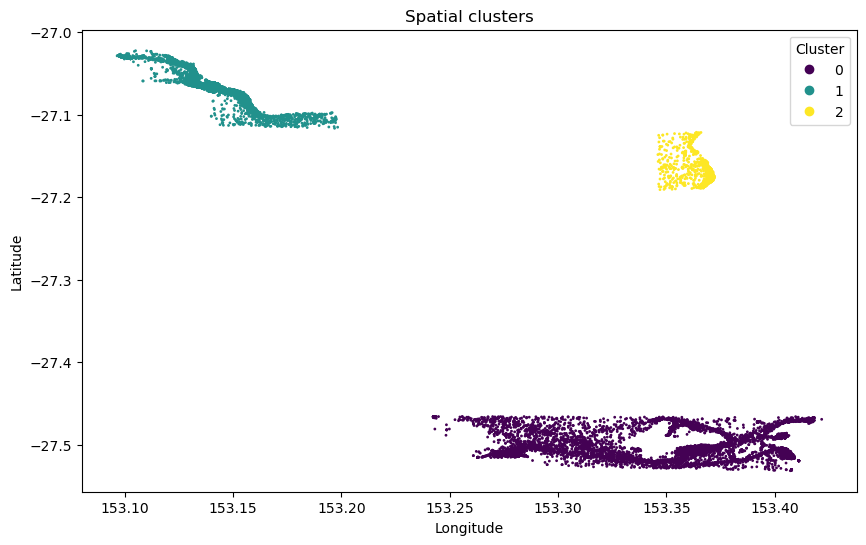

,date,class,latitude,longitude,confidence,AOI,images,w,h,cluster
0,2016-07-23,0.0,-27.029093,153.099683,0.602136,south_bribie,NaN,NaN,NaN,1
1,2016-07-23,0.0,-27.043734,153.131123,0.782813,south_bribie,NaN,NaN,NaN,1
2,2016-07-23,0.0,-27.073810,153.147421,0.690460,south_bribie,NaN,NaN,NaN,1
3,2016-07-23,0.0,-27.069445,153.138789,0.832270,south_bribie,NaN,NaN,NaN,1
4,2016-07-23,0.0,-27.028120,153.097550,0.746432,south_bribie,NaN,NaN,NaN,1


In [4]:
# break the data spatially into 3 clusters (ignoring AOIS)
from sklearn.cluster import KMeans

X = data[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
data['cluster'] = kmeans.labels_
# get rid of the outliers (great barrier reef)
data = data[data['cluster'] == 0]

# now cluster again with 3 clusters
X = data[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
data['cluster'] = kmeans.labels_

# plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['longitude'], data['latitude'], c=data['cluster'], s=1)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial clusters")
plt.show()

# north-most cluster is south_bribie
# south-most cluster is peel
# middle cluster is tangalooma

# assign the AOI to each cluster
data.loc[data['cluster'] == 0, 'AOI'] = 'peel'
data.loc[data['cluster'] == 1, 'AOI'] = 'south_bribie'
data.loc[data['cluster'] == 2, 'AOI'] = 'tangalooma'

data.head()



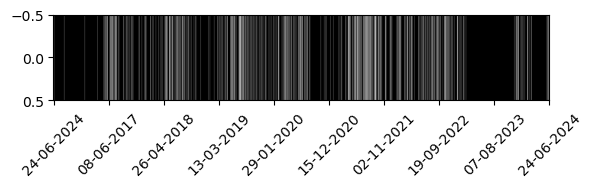

In [5]:
import matplotlib.pyplot as plt
# Visualise the missing dates
dates_we_have = data['date'].value_counts().sort_index()
mask = np.isin(date_range, dates_we_have.index)
mask = mask.reshape(1, -1)
# visualise the mask 
fig, ax = plt.subplots()
ax.imshow(mask, aspect=500, cmap='gray')
x = np.linspace(0, len(date_range), 10)
ax.set_xticks(x)
ax.set_xticklabels([date_range[int(i-1)].strftime("%d-%m-%Y") for i in x], rotation=45)

plt.show()

In [6]:
# Biggest run of consecutive dates we have
consecutive_dates = np.diff(np.where(np.diff(np.where(mask == 0)) == 1))
print("Longest run of consecutive dates we have:", consecutive_dates.max())

Longest run of consecutive dates we have: 6


## Visualise some data spatially

In [7]:
# work out some limits
x_min = data['longitude'].min()
x_max = data['longitude'].max()
y_min = data['latitude'].min()
y_max = data['latitude'].max()

# add a 5% margin to the limits
x_margin = 0.05 * (x_max - x_min)
y_margin = 0.05 * (y_max - y_min)
x_min -= x_margin
x_max += x_margin
y_min -= y_margin
y_max += y_margin

print(x_min, x_max, y_min, y_max)


153.08023391676807 153.43790584485376 -27.557192707068122 -26.99721188145715


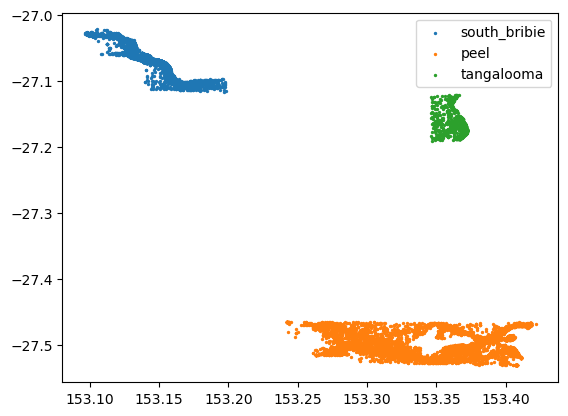

In [8]:

# plot all the boats
fig, ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
for aoi in data['AOI'].unique():
    aoi_data = data[data['AOI'] == aoi]
    ax.scatter(aoi_data['longitude'], aoi_data['latitude'], label=aoi, s=2)
ax.legend()
plt.show()

# *******************************
# This works but takes time
# *******************************

# Do an animation through the days boats
# import matplotlib.animation as animation
# fig, ax = plt.subplots()
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# sc = ax.scatter([], [])
# def update(day):
#     day_data = data[data['date'] == dates_we_have.index[day]]
#     sc.set_offsets(day_data[['longitude', 'latitude']])
#     # set the title to the date
#     ax.set_title(dates_we_have.index[day])
#     return sc,
# ani = animation.FuncAnimation(fig, update, frames=len(dates_we_have), interval=100)

# ani.save('data/boat_animation.mp4', writer='ffmpeg', fps=4)


We have 19759 entries over 216 days for peel
2016-09-26 00:00:00 2024-06-24 00:00:00
day_of_week
0    1758
1    1645
2    2078
3    2169
4    3880
5    4100
6    4129
Name: count, dtype: int64


/var/folders/8m/ly22v28n5c95xl76kl22fczh0000gn/T/ipykernel_91226/3323270349.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoi_data['day_of_week'] = aoi_data['date'].dt.dayofweek


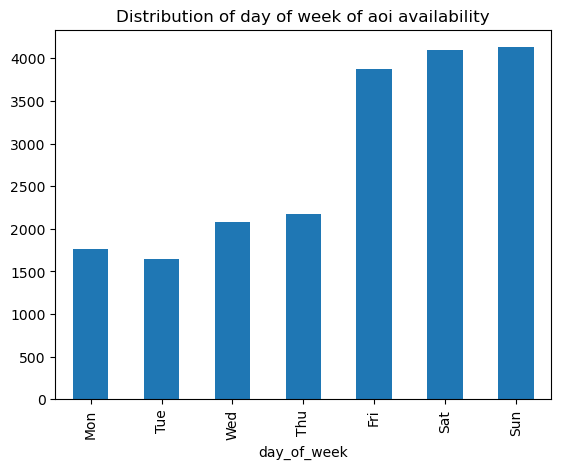

In [9]:
# Peel island is just all entries with AOI = peelIsland
AOI = 'peel'
aoi_data = data[data['AOI'] == AOI]
print("We have {} entries over {} days for {}".format(len(aoi_data), len(pd.unique(aoi_data['date'])), AOI))
aoi_data.head()
# print the range of dates we have
print(aoi_data['date'].min(), aoi_data['date'].max())


# distribution of day of week
aoi_data['day_of_week'] = aoi_data['date'].dt.dayofweek
day_of_week = aoi_data['day_of_week'].value_counts().sort_index()
# normalise based on the number of days we have
print(day_of_week)
fig, ax = plt.subplots()
day_of_week.plot(kind='bar', ax=ax)
ax.title.set_text('Distribution of day of week of aoi availability')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


In [10]:
# Load the weather data
weather = pd.read_csv("visualisation/data/weather.csv")
# convert the date to a datetime
weather['date'] = pd.to_datetime(weather['YYYY-MM-DD'])
weather = weather.drop(columns=['YYYY-MM-DD', 'metadata'])
weather.head()


,latitude,longitude,daily_rain,daily_rain_source,max_temp,max_temp_source,min_temp,min_temp_source,rh_tmax,rh_tmax_source,date
0,-27.5,153.3,0.0,25,28.4,25,18.9,25,46.0,26,2016-01-01
1,-27.5,153.3,0.0,25,28.5,25,17.6,25,45.5,26,2016-01-02
2,-27.5,153.3,0.1,25,27.6,25,20.2,25,57.1,26,2016-01-03
3,-27.5,153.3,4.3,25,27.5,25,19.0,25,60.8,26,2016-01-04
4,-27.5,153.3,29.9,25,25.9,25,20.1,25,70.6,26,2016-01-05


# Interpolation

In [11]:
# Build the dataset for machine learning:
# Put together the weather and boat data, lets start with count per day
# First dataset: date, count, daily_rain, max_temp, min_temp 

peel_grouped = aoi_data.groupby('date')
peel_counts = peel_grouped.size()
peel_counts = peel_counts.reset_index()
peel_counts.columns = ['date', 'count']

weather_columns = ['date', 'daily_rain', 'max_temp', 'min_temp', 'rh_tmax']
weather = weather[weather_columns]

data = pd.merge(peel_counts, weather, on='date', how='inner')
data['day_of_week'] = data['date'].dt.dayofweek
data['season'] = (data['date'].dt.month % 12 + 3) // 3
data['year'] = data['date'].dt.year
# one hot encode the date data
data = pd.get_dummies(data, columns=['day_of_week', 'season', 'year'], drop_first=True, dtype=int)
print("Observations:", data.shape[0])

# normalise the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['daily_rain', 'max_temp', 'min_temp']] = scaler.fit_transform(data[['daily_rain', 'max_temp', 'min_temp']])

data.head()

Observations: 216


,date,count,daily_rain,max_temp,min_temp,rh_tmax,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,season_3,season_4,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,2016-09-26,14,0.005181,0.402844,0.434555,39.4,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2017-04-08,2,0.005181,0.436019,0.554974,55.6,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2017-05-17,2,0.000000,0.364929,0.366492,51.7,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2017-06-01,19,0.000000,0.203791,0.178010,42.0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
4,2017-06-03,24,0.000000,0.279621,0.230366,43.9,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


Error: 58.950877010454946


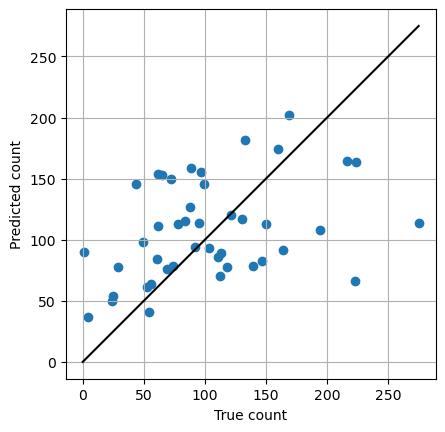

Error: 50.59681012480423


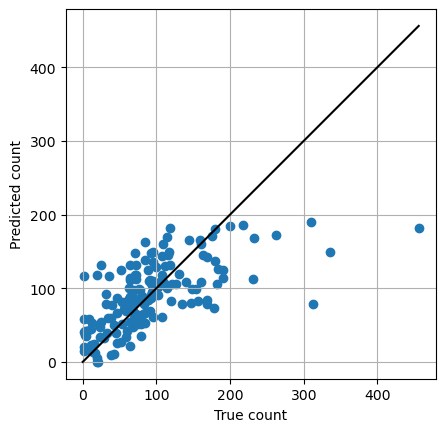

In [12]:
# Now we can build a simple linear regression model to predict the count of boats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

x_cols = [col for col in data.columns if col not in ['date', 'count']]

X = data[x_cols]

y = data['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)
print("Error:", err)

# plot the predictions
def plot_predictions(y_test, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred)
    ax.set_xlabel('True count')
    ax.set_ylabel('Predicted count')
    # grid
    ax.grid(True)
    # add the line y = x
    ax.plot([0, y_test.max()], [0, y_test.max()], color='black')
    # make the aspect ratio equal
    ax.set_aspect('equal', adjustable='box')
    plt.show()

plot_predictions(y_test, y_pred)

# plot predictions for the training data
y_pred_train = model.predict(X_train)

Err = rmse(y_train, y_pred_train)
print("Error:", Err)

plot_predictions(y_train, y_pred_train)




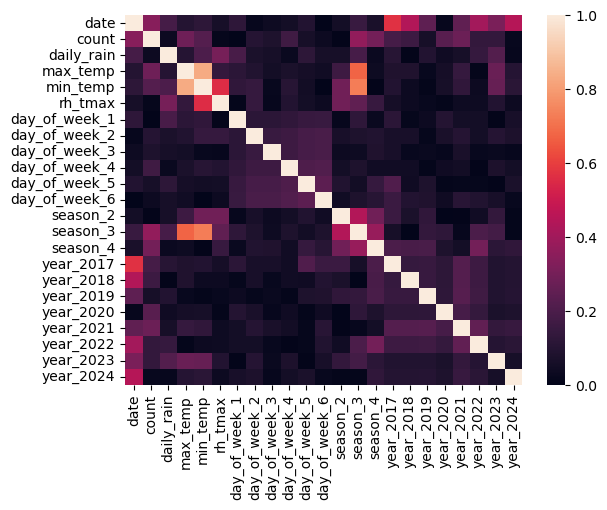

In [13]:
# Plot a heatmap of the correlation matrix
import seaborn as sns
corr = data.corr()
fig, ax = plt.subplots()
sns.heatmap(corr.abs(), ax=ax)
plt.show()


In [14]:
# Try a more complex model like RF
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)

print("Test Error RMSE:", err)

# plot the predictions

# plot_predictions(y_test, y_pred)
y_pred_train = model.predict(X_train)
Err = rmse(y_train, y_pred_train)
print("Train Error RMSE:", Err)




Test Error RMSE: 68.51838704783091
Train Error RMSE: 19.957370105092203


In [15]:
# Try a neural network
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(32, 64, 128, 256, 128, 64, 32), random_state=42, max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)
print("Test Error RMSE:", err)
y_train_pred = model.predict(X_train)
Err = rmse(y_train, y_train_pred)
print("Train Error RMSE:", Err)
# plot_predictions(y_test, y_pred)

Test Error RMSE: 66.55779339077212
Train Error RMSE: 69.68195434924564


False
=== Epoch   16000 loss: 27.864 val_loss: 5729.121 Best val_loss: 3301.168 at epoch    6525 ====
Stopping early at epoch 16526

Validation Error RMSE: 57.455788


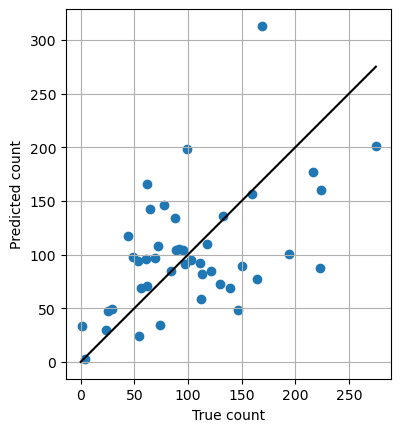

Training Error RMSE: 35.390934


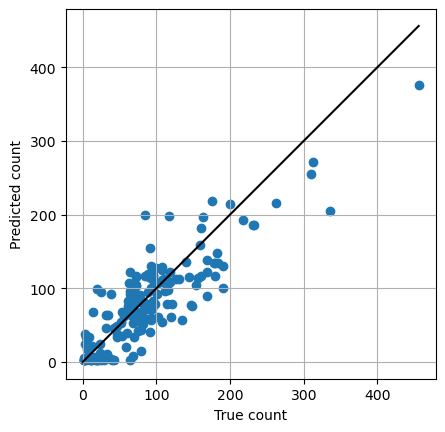

In [16]:
# Try a simple fully connected neural network
import torch

class BoatModel(torch.nn.Module):
    def __init__(self, input_size):
        super(BoatModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 128)
        self.fc3 = torch.nn.Linear(128, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 64)
        self.fc6 = torch.nn.Linear(64, 32)
        self.fc7 = torch.nn.Linear(32, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x

class VarPenalisedMSELoss(torch.nn.Module):
    def __init__(self, penalty=0.1):
        super(VarPenalisedMSELoss, self).__init__()
        self.penalty = penalty
    def forward(self, y_pred, y_true):
        loss = torch.mean((y_pred - y_true) ** 2)
        var = torch.var(y_pred)
        return loss + self.penalty * var
    

model = BoatModel(X_train.shape[1])
criterion = VarPenalisedMSELoss(penalty=0)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

# oversample high y values to balance the dataset 
y_bins = np.linspace(y_train.min(), y_train.max(), 10)
count = np.histogram(y_train, bins=y_bins)[0]
weights = 1 / (count+1)
sample_weights = weights[(np.digitize(y_train-1, y_bins) - 1)]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(y_train), replacement=True)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=round(X_train.shape[0]/2),
                                           sampler=sampler)


X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

best_after = 1000
best_epoch = 0
best_val_loss = np.inf
best_model = None

losses = []
val_losses = []

# print out if torch is using mps
print(torch.cuda.is_available())

for epoch in range(100000):
    optimizer.zero_grad()
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
    optimizer.step()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)
        if epoch % 1000 == 0:
            print(f"=== Epoch {epoch:7} loss: {loss.item():4.3f} val_loss: {val_loss.item():4.3f} Best val_loss: {best_val_loss:4.3f} at epoch {best_epoch:7} ===", end="\r")
        losses.append(loss.item())
        val_losses.append(val_loss.item())
        if val_loss < best_val_loss and epoch > best_after:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model = BoatModel(X_train.shape[1])
            best_model.load_state_dict(model.state_dict())
        if epoch - best_epoch > 10000:
            print(f"\nStopping early at epoch {epoch}")
            break
print()


y_pred = best_model(X_test_tensor)
err = rmse(y_test_tensor.detach().numpy(), y_pred.detach().numpy())
print("Validation Error RMSE:", err)

plot_predictions(y_test_tensor.detach().numpy(), y_pred.detach().numpy())

# plot predictions over training data
y_pred = best_model(X_train_tensor)
err = rmse(y_train_tensor.detach().numpy(), y_pred.detach().numpy())
print("Training Error RMSE:", err)

plot_predictions(y_train_tensor.detach().numpy(), y_pred.detach().numpy())

In [18]:
# Use ARIMA
from statsmodels.tsa.arima.model import ARIMA

# build the dataset
peel_grouped = aoi_data.groupby('date')
peel_counts = peel_grouped.size()
peel_counts = peel_counts.reset_index()
peel_counts.columns = ['date', 'count']

weather_columns = ['date', 'daily_rain', 'max_temp', 'min_temp', 'rh_tmax']
weather = weather[weather_columns]

data = pd.merge(peel_counts, weather, on='date', how='inner')
data['day_of_week'] = data['date'].dt.dayofweek
data['season'] = (data['date'].dt.month % 12 + 3) // 3
data['year'] = data['date'].dt.year
# one hot encode the date data
data = pd.get_dummies(data, columns=['day_of_week', 'season', 'year'], drop_first=True, dtype=int)
print("Observations:", data.shape[0])

# normalise the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['daily_rain', 'max_temp', 'min_temp']] = scaler.fit_transform(data[['daily_rain', 'max_temp', 'min_temp']])
                                                                    
data = data.set_index('date')
data = data.resample('D').mean()
data = data.fillna(method='ffill')
data = data.dropna()

data.head()

# split the data
train = data.loc[:'2021-01-01']
test = data.loc['2021-01-01':]

model = ARIMA(train['count'], order=(5, 1, 0))
model = model.fit()
y_pred = model.predict(start=test.index[0], end=test.index[-1], typ='levels')

err = rmse(test['count'], y_pred)
print("Error:", err)

plot_predictions(test['count'], y_pred)

# plot the residuals
residuals = test['count'] - y_pred
fig, ax = plt.subplots()
ax.plot(residuals)
ax.set_title("Residuals")
plt.show()






ModuleNotFoundError: No module named 'statsmodels'